In [656]:
import numpy as np # Numpy is a popular numeric computation package
import pandas as pd # Pandas is a friendly data wrangling package/library
from scipy import linalg
import matplotlib.pyplot as pl

# Setting a specific random seed, to get reproducibility across students.
# @Students, you can remove or change to your own seed to try with your own training subsets.
np.random.seed(100) 

In [657]:
import pandas as pd
import numpy as np

# Transformation (BoxCox)
from scipy import stats
from scipy.special import boxcox, inv_boxcox

# Plotting
import plotly.express as px
import plotly.graph_objects as go

import torch
import gpytorch
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

# Reproducibility
import watermark

In [658]:
adt = pd.read_csv("../Warping-tests/engineered_data/assay_desurveyed_transformed_Mlith_domain.csv")
domained = pd.read_csv('../Warping-tests/engineered_data/blockmodel_domained_NN.csv')

In [659]:
adt.MLITHGROUPINGS2.unique()

array(['CLAY', 'AND_BAD_BIGD_RHY', 'IGN', 'QMD', 'FLT_HBX_HWS', 'VA',
       'INTR'], dtype=object)

In [660]:
# subset assay data by domains
adt_FLT_HBX_HWS = adt[adt["MLITHGROUPINGS2"] == "INTR"]
adt_FLT_HBX_HWS_Cu = adt_FLT_HBX_HWS.loc[:,["HOLEID", 'EAST_mid_tf', 'NORTH_mid_tf', 'RL_mid_tf', 'Cu_pct']]

# NaN values causing trouble
#adt_FLT_HBX_HWS_Cu["Cu_pct"] = adt_FLT_HBX_HWS_Cu["Cu_pct"].fillna(0)
print(adt_FLT_HBX_HWS_Cu["Cu_pct"].isna().sum())
adt_FLT_HBX_HWS_Cu

0


,HOLEID,EAST_mid_tf,NORTH_mid_tf,RL_mid_tf,Cu_pct
1717,OTD1425,-489.699937,93.725340,1747.734096,0.00000
3310,OTD1769,445.987252,1190.506493,277.690835,0.01285
3311,OTD1769,446.779556,1190.589769,275.856367,0.22400
4587,OTD1772,-367.617547,98.543817,1717.673993,0.06670
4588,OTD1772,-367.981943,98.529202,1715.707525,0.01400
...,...,...,...,...,...
42351,OTRC2402,171.934690,110.366182,1612.646600,0.00000
42352,OTRC2402,171.287201,110.909489,1610.833984,0.00000
42356,OTRC2402,168.697246,113.082719,1603.583522,0.00000
42358,OTRC2402,167.402269,114.169335,1599.958291,0.00000


In [661]:
adt_FLT_HBX_HWS_Cu = adt_FLT_HBX_HWS_Cu.dropna(subset=['Cu_pct'])

In [662]:
x = adt_FLT_HBX_HWS_Cu[['EAST_mid_tf','NORTH_mid_tf', 'RL_mid_tf']].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
y = adt_FLT_HBX_HWS_Cu['Cu_pct'].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
x = x.reshape(len(adt_FLT_HBX_HWS_Cu),3)

print(f"x has shape ({x.shape[0]},{x.shape[1]}) and has range [{np.min(x):.3f},{np.max(x):.3f}]")
print(f"y has shape ({y.shape[0]},{y.shape[1]}) and has range [{np.min(y):.3f},{np.max(y):.3f}]")

x has shape (230,3) and has range [-489.700,1747.734]
y has shape (230,1) and has range [0.000,1.055]


In [112]:
def calc_moving_avg(dataframe, variable_name_str, window_size = 5, ):
    index_var = int(np.where(adt_FLT_HBX_HWS_Cu.columns == "Cu_pct")[0])
    i = 0
    # List fo all holeids
    holeid_list = np.unique(dataframe["HOLEID"]).reshape(-1)
    # empty container
    moving_avg_list = []
    # Iterate over all holes
    for i in range(holeid_list.shape[0]):
        # Retrieve name of holeid
        holeid = holeid_list[i]
        # Create subset
        dataframe_holeid_subset = dataframe[dataframe["HOLEID"] == holeid]
        # Iterate over all rows in subset
        subset_length = dataframe_holeid_subset.shape[0]
        j = 0
        # end not included
        for j in range(subset_length):
            if (j < ((window_size - 1)/2)):
                ma = np.mean(dataframe_holeid_subset.iloc[0:int(j + ((window_size - 1)/2) + 1), index_var])
                moving_avg_list.append(ma)
                j = j + 1
            elif (j > (subset_length - ((window_size - 1)/2) - 2)):
                ma = np.mean(dataframe_holeid_subset.iloc[j:subset_length, index_var])
                moving_avg_list.append(ma)
                j = j + 1
            else:
                ma = np.mean(dataframe_holeid_subset.iloc[(j-2):(j+3), index_var])
                moving_avg_list.append(ma)
                j = j + 1
        i = i + 1
    return(moving_avg_list)

In [134]:
moving_average_list = calc_moving_avg(window_size = 5, dataframe = adt_FLT_HBX_HWS_Cu, variable_name_str = "Cu_pct")

adt_FLT_HBX_HWS_Cu["moving_average_Cu_pct"] = moving_average_list

In [135]:
epsilon_boxcox_shift = 0.00001
xt, maxlog_lamda = stats.boxcox(adt_FLT_HBX_HWS_Cu["moving_average_Cu_pct"] + epsilon_boxcox_shift)
print(f"The maxlog lamda parameter used for the BoxCox transformation was {maxlog_lamda}")

xt_df = pd.DataFrame(data = {"bc_ma_Cu_pct" : xt})
fig = px.histogram(xt_df, x = "bc_ma_Cu_pct",
                  title = "Distribution of BoxCox transformed moving average Cu_pct values")
fig.show()

The maxlog lamda parameter used for the BoxCox transformation was 0.1672159022176572


In [136]:
adt_FLT_HBX_HWS_Cu["bc_ma_Cu_pct"] = xt

# print(stats.boxcox(x = (adt_FLT_HBX_HWS_Cu["moving_average_Cu_pct"] + epsilon_boxcox_shift), lmbda = maxlog_lamda))
# print(boxcox((adt_FLT_HBX_HWS_Cu["moving_average_Cu_pct"] + epsilon_boxcox_shift), maxlog_lamda))

# Slightly off (overflow)
print(inv_boxcox(adt_FLT_HBX_HWS_Cu["bc_ma_Cu_pct"], maxlog_lamda) + epsilon_boxcox_shift)
print(adt_FLT_HBX_HWS_Cu["moving_average_Cu_pct"])

# Not standard normal, not zero-mean
np.mean(adt_FLT_HBX_HWS_Cu["bc_ma_Cu_pct"])
np.std(adt_FLT_HBX_HWS_Cu["bc_ma_Cu_pct"])


1717     0.000020
3310     0.118445
3311     0.118445
4587     0.029477
4588     0.023432
           ...   
42351    0.000020
42352    0.000020
42356    0.000020
42358    0.000020
42359    0.000020
Name: bc_ma_Cu_pct, Length: 230, dtype: float64
1717     0.000000
3310     0.118425
3311     0.118425
4587     0.029457
4588     0.023412
           ...   
42351    0.000000
42352    0.000000
42356    0.000000
42358    0.000000
42359    0.000000
Name: moving_average_Cu_pct, Length: 230, dtype: float64


1.0275565573145868

In [663]:
holeid_list = np.unique(adt_FLT_HBX_HWS_Cu["HOLEID"]).reshape(-1)
# 150 holdeids for training
# 65 holeids for val
int(holeid_list.shape[0] * 0.7)

np.random.seed(42)

train_index_list = np.random.choice(holeid_list.shape[0], size = int(holeid_list.shape[0] * 0.7), replace = False)
val_index_list = list(set(range(holeid_list.shape[0])).difference(train_index_list))

holeid_list[train_index_list]
holeid_list[val_index_list]

train_subset = adt_FLT_HBX_HWS_Cu[adt_FLT_HBX_HWS_Cu["HOLEID"].isin(holeid_list[train_index_list])]
val_subset = adt_FLT_HBX_HWS_Cu[adt_FLT_HBX_HWS_Cu["HOLEID"].isin(holeid_list[val_index_list])]

In [664]:
train_subset

,HOLEID,EAST_mid_tf,NORTH_mid_tf,RL_mid_tf,Cu_pct
1717,OTD1425,-489.699937,93.725340,1747.734096,0.00000
3310,OTD1769,445.987252,1190.506493,277.690835,0.01285
3311,OTD1769,446.779556,1190.589769,275.856367,0.22400
4587,OTD1772,-367.617547,98.543817,1717.673993,0.06670
4588,OTD1772,-367.981943,98.529202,1715.707525,0.01400
...,...,...,...,...,...
42351,OTRC2402,171.934690,110.366182,1612.646600,0.00000
42352,OTRC2402,171.287201,110.909489,1610.833984,0.00000
42356,OTRC2402,168.697246,113.082719,1603.583522,0.00000
42358,OTRC2402,167.402269,114.169335,1599.958291,0.00000


In [693]:
# training data: torch.tensor format. Division my 1000 to have input and output dimensions similar
train_x = np.array(train_subset.loc[:,['EAST_mid_tf', 'NORTH_mid_tf', 'RL_mid_tf']])
# y expected to be scalar
#train_y = np.array(train_subset.loc[:,['bc_ma_Cu_pct']])
train_y = np.array(train_subset.loc[:,['Cu_pct']])*100

# Validation data: torch.tensor format 
val_x = np.array(val_subset.loc[:,['EAST_mid_tf', 'NORTH_mid_tf', 'RL_mid_tf']])
# y expected to be scalar
#val_y = np.array(val_subset.loc[:,['bc_ma_Cu_pct']])
val_y = np.array(val_subset.loc[:,['Cu_pct']])*100

# MA: moving average (not transformed)

print(train_x.shape)
print(train_y.shape)

(118, 3)
(118, 1)


In [167]:
def transform_to_tanh(y, a, b, c):
    """
    Transforms a given variable to its hyperbolic tangent as a weighted sum.

    Args:
        t: A scalar or tensor to be transformed.
        a: A 1D numpy array of length I containing the weights for each element in the sum.
        b: A 1D numpy array of length I containing the scaling factors for each element in the sum.
        c: A 1D numpy array of length I containing the offsets for each element in the sum.

    Returns:
        The hyperbolic tangent of y.
    """
    # Compute the weighted sum of hyperbolic tangents
    f = np.sum(a * np.tanh(b * (y + c)))
    
    return f

In [166]:
def derivative_tanh(y, a, b, c):
    """
    Computes the derivative of a given function with respect to t.

    Args:
        t: A scalar or tensor with respect to which to take the derivative.
        a: A 1D numpy array of length I containing the weights for each element in f.
        b: A 1D numpy array of length I containing the scaling factors for each element in f.
        c: A 1D numpy array of length I containing the offsets for each element in f.

    Returns:
        The derivative of f with respect to t.
    """
    # Compute the derivative of f with respect to t using the chain rule
    df_dy = np.sum(a * b * (1 - np.tanh(b * (y + c)) ** 2))
    
    return df_dy

In [696]:
class GP:
    def __init__(self,cov_function_name, x_train, y_train, hyper_params, sigma_n):
        self.cov_function_name = cov_function_name
        self.x_train = x_train
        self.y_train = y_train
        self.hyper_params = hyper_params #params[0] is signal variance, params[1] is lengthscale
        self.K = self.cov_func(self.x_train,self.x_train)
        self.sigma_n = sigma_n
        self.K_inv = np.linalg.pinv(self.K+np.eye(self.K.shape[0])*(self.sigma_n**2))
        
    def predict(self,x_star):
        k_star = self.cov_func(self.x_train,x_star)
        f_mean = np.dot(np.dot(np.transpose(k_star),self.K_inv),self.y_train)
        f_std = self.cov_func(x_star, x_star) - np.dot(np.dot(np.transpose(k_star),self.K_inv),k_star)+np.eye(x_star.shape[0])*(self.sigma_n**2)
        f_std = np.sqrt(np.diag(f_std))[:,np.newaxis]
        return [f_mean,f_std]

    def cov_func(self,x_1,x_2):
        if self.cov_function_name == "Squared Exponential":
            x_1_sq = np.sum(np.square(x_1),1)
            x_2_sq = np.sum(np.square(x_2),1)
            d = -2.*np.dot(x_1, x_2.T) + (x_1_sq[:,None] + x_2_sq[None,:])
            d = np.sqrt(np.clip(d, 0, np.inf)/self.hyper_params[1])
            K = self.hyper_params[0] * np.exp(-0.5 * d**2)
        return K
    
    def set_hyper_params(self, hyper_params, sigma_n):
        self.hyper_params = hyper_params
        self.K = self.cov_func(self.x_train,self.x_train)
        self.sigma_n = sigma_n
        self.K_inv = np.linalg.pinv(self.K+np.eye(self.K.shape[0])*(self.sigma_n**2))
        
    def log_marginal_likelihood(self):
        lml1 = -.5*np.dot(np.dot(np.transpose(self.y_train),self.K_inv),self.y_train)
        lml2 = -.5*np.log(np.linalg.det(self.K+np.eye(self.K.shape[0])*(self.sigma_n**2)))
        lml3 = -.5*self.x_train.shape[0]*np.log(2*np.pi)
        return lml1+lml2+lml3
        

In [767]:
signal_variance = 0.15 #1
lengthscale = 50000 #0.3
sigma_n = 0.1 #0.1
gp = GP("Squared Exponential", train_x, train_y, [signal_variance,lengthscale], sigma_n)
[f_mean_2,f_std_2] = gp.predict(val_x)
lml = gp.log_marginal_likelihood()
print("Log Marginal Likelihood: "+str(lml))
print(np.mean(f_mean_2), np.mean(val_y))
print(np.max(f_mean_2), np.max(val_y))


Log Marginal Likelihood: [[-385346.743442]]
7.133386126403184 4.698083928571429
9.745265385243826 105.5


In [771]:
from scipy.optimize import minimize

def eval_params(params, gp):
    params = np.exp(params)
    gp.set_hyper_params(params[:-1],params[len(params)-1])
    nlml = -gp.log_marginal_likelihood()
    print(str(params)+str(nlml))
    return nlml

x0 = np.array([np.log(0.15), np.log(50000), np.log(0.1)])
res = minimize(eval_params, x0, method='nelder-mead', args=(gp),
               options={'xatol': 1e-10, 'disp': True})
print(res)

[0.150000 50000.000000 0.100000][[385346.743442]]
[0.136426 50000.000000 0.100000][[386430.947387]]
[0.150000 85885.234257 0.100000][[396616.280257]]
[0.150000 50000.000000 0.089125][[482012.845250]]
[0.140808 71713.734301 0.112202][[314721.340582]]
[0.136426 85885.234257 0.125893][[255367.074841]]
[0.132179 41749.745996 0.116591][[285058.424718]]
[0.142300 63590.400464 0.129155][[238182.097364]]
[0.145331 71713.734301 0.146780][[187422.775391]]
[0.126723 80874.780624 0.166810][[148483.214599]]
[0.116476 102857.193748 0.215443][[92065.371806]]
[0.132179 176678.283600 0.215443][[93281.691595]]
[0.125394 138918.989588 0.285467][[53722.739891]]
[0.120218 176678.283600 0.429866][[24517.974602]]
[0.103726 303481.115501 0.501187][[18582.320359]]
[0.087630 624304.317917 0.926119][[5826.804301]]
[0.086711 285776.348545 0.902725][[6069.267625]]
[0.080827 970143.230023 2.346229][[1155.828824]]
[0.067332 2979452.392659 7.742637][[443.739128]]
[0.053210 3714122.381387 8.079926][[441.445642]]
[0.03

c:\Users\23478671\Anaconda3\envs\geostatistics\lib\site-packages\numpy\linalg\linalg.py:2146: RuntimeWarning:

overflow encountered in det



[0.056194 5611543.419438 10.825106][[437.900094]]
[0.062834 6567849.762432 13.124743][[445.214346]]
[0.055468 4282998.869775 9.121752][[437.276887]]
[0.058474 3854317.795503 8.231228][[440.431951]]
[0.056978 4972910.267067 10.384958][[437.154785]]
[0.059324 3430697.132615 8.299762][[440.048364]]
[0.056961 4962006.634428 10.129559][[436.877883]]
[0.052350 5636447.556616 10.821446][[437.915251]]
[0.058641 4330172.786396 9.416600][[436.846781]]
[0.059650 5257357.378390 10.893849][[438.023565]]
[0.056485 4508196.576178 9.535732][[436.780775]]
[0.057735 4241306.438183 9.039707][[437.411893]]
[0.057166 4778954.327613 10.030952][[436.804218]]
[0.057891 4145433.571163 9.207386][[437.107323]]
[0.057192 4743899.670546 9.890699][[436.736543]]
[0.055301 5048266.273275 10.234218][[436.988238]]
[0.057788 4499502.352390 9.614667][[436.732868]]
[0.057139 4394090.550842 9.339738][[436.938784]]
[0.057159 4679688.123311 9.853495][[436.726495]]
[0.058287 4775385.261307 10.041848][[436.802541]]
[0.056930 4

In [772]:
optimal_params = np.exp(res.x)

print("Optimal signal variance: "+str(optimal_params[0]))
print("Optimal lengthscale: "+str(optimal_params[1]))
print("Optimal noise std: "+str(optimal_params[2]))

gp.set_hyper_params([optimal_params[0],optimal_params[1]],optimal_params[2])

#Predict for x_star
[f_mean,f_std] = gp.predict(val_x)
lml = gp.log_marginal_likelihood()

print("Log Marginal Likelihood: "+str(lml))



Optimal signal variance: 33.222849156427216
Optimal lengthscale: 5131.692786973009
Optimal noise std: 8.409719291988935
Log Marginal Likelihood: [[-426.980485]]


In [699]:
class GPwarp:
    def __init__(self,cov_function_name, x_train, y_train, hyper_params, sigma_n, nu=None):
        self.cov_function_name = cov_function_name
        self.x_train = x_train
        self.y_train = y_train
        self.hyper_params = hyper_params #hyper_params[0] are the GP's, hyper_params[1] are the warpings
        self.nu = nu
        self.gamma = self.hyper_params[1]
        self.K = self.cov_func(self.x_train,self.x_train)
        self.sigma_n = sigma_n
        self.K_inv = np.linalg.pinv(self.K+np.eye(self.K.shape[0])*(self.sigma_n**2))
        self.f = 0
        self.df_dy = 0
        self.a0 = self.gamma[0]
        self.b0 = self.gamma[1]
        self.c0 = self.gamma[2]
        for i in range(len(self.gamma[0])):
            self.f += self.a0[i] * np.tanh(self.b0[i] * (self.y_train + self.c0[i])) 
            self.df_dy += self.a0[i] * self.b0[i] * (1 - np.tanh(self.b0[i] * (self.y_train + self.c0[i])) ** 2)

    def predict(self,x_star):
        k_star = self.cov_func(self.x_train,x_star)
        f_mean = np.dot(np.dot(np.transpose(k_star),self.K_inv),self.f)
        f_std = self.cov_func(x_star, x_star) - np.dot(np.dot(np.transpose(k_star),self.K_inv),k_star)+np.eye(x_star.shape[0])*(self.sigma_n**2)
        f_std = np.sqrt(np.diag(f_std))[:,np.newaxis]
        return [f_mean,f_std]


    def predict_original(self,x_star):
        k_star = self.cov_func(self.x_train,x_star)
        y_mean = np.dot(np.dot(np.transpose(k_star),self.K_inv),self.y_train)
        y_std = self.cov_func(x_star, x_star) - np.dot(np.dot(np.transpose(k_star),self.K_inv),k_star)+np.eye(x_star.shape[0])*(self.sigma_n**2)
        y_std = np.sqrt(np.diag(y_std))[:,np.newaxis]
        return [y_mean,y_std]

    def cov_func(self,x_1,x_2):
        
        x_1_sq = np.sum(np.square(x_1),1)
        x_2_sq = np.sum(np.square(x_2),1)
        d = -2.*np.dot(x_1, x_2.T) + (x_1_sq[:,None] + x_2_sq[None,:])
        d = np.sqrt(np.clip(d, 0, np.inf))

        if self.cov_function_name == "Squared Exponential":
            K = self.hyper_params[0][0] * np.exp(-0.5 * (d**2)/self.hyper_params[0][1])

        if self.cov_function_name == "Matern":

            if self.nu == 5/2:
                K = self.hyper_params[0][0] *(1 + np.sqrt(5) * d / self.hyper_params[0][1] + 5 * d ** 2 / (3 * self.hyper_params[0][1] ** 2)) \
                        * np.exp(-np.sqrt(5) * d / self.hyper_params[0][1])

            elif self.nu == 1/2:
                K = self.hyper_params[0][0] *np.exp(-0.5*(d/self.hyper_params[0][1])**2)
    
            else: 
                print('invalid nu')
                
        return K

    def set_hyper_params(self, hyper_params, sigma_n):
        self.hyper_params = hyper_params
        self.K = self.cov_func(self.x_train,self.x_train)
        self.sigma_n = sigma_n
        self.K_inv = np.linalg.pinv(self.K+np.eye(self.K.shape[0])*(self.sigma_n**2))

        self.gamma = self.hyper_params[1]
        self.a = self.gamma[0]
        self.b = self.gamma[1]
        self.c = self.gamma[2]
        self.f = 0
        self.df_dy = 0
        for i in range(len(self.gamma[0])):
            self.f += self.a[i] * np.tanh(self.b[i] * (self.y_train + self.c[i])) 
            self.df_dy += self.a[i] * self.b[i] * (1 - np.tanh(self.b[i] * (self.y_train + self.c[i])) ** 2)
            
    def log_marginal_likelihood(self):
        lml1 = -.5*np.dot(np.dot(np.transpose(self.f),self.K_inv),self.f)
        lml2 = -.5*np.log(np.linalg.det(self.K+np.eye(self.K.shape[0])*(self.sigma_n**2)))
        lml3 = -.5*self.x_train.shape[0]*np.log(2*np.pi)
        lml4 = np.sum(np.log(self.df_dy))
        return lml1+lml2+lml3+lml4

    def log_marginal_likelihood_original(self):
        lml1 = -.5*np.dot(np.dot(np.transpose(self.y_train),self.K_inv),self.y_train)
        lml2 = -.5*np.log(np.linalg.det(self.K+np.eye(self.K.shape[0])*(self.sigma_n**2)))
        lml3 = -.5*self.x_train.shape[0]*np.log(2*np.pi)
        return lml1+lml2+lml3

In [700]:
I = 1
val_a = 2 
val_b = 2
val_c = 0
a = np.full(I, val_a)
b = np.full(I, val_b)
c = np.full(I, val_c)

nuv = 1/2

signal_variance = 2000000 #1
lengthscale = 300 #0.3
sigma_n = 0.1 #0.1
gpw = GPwarp("Matern", train_x, train_y, [[signal_variance,lengthscale],[a,b,c]], sigma_n, 5/2)
[fw_mean_2,fw_std_2] = gpw.predict(val_x)
lml = gp.log_marginal_likelihood()
print("Log Marginal Likelihood: "+str(lml))
print(np.max(fw_mean_2), np.max(val_y))


fw_norm_train = 0
fw_norm_test = 0
for i in range(I):
    fw_norm_train += a[i]* np.tanh(b[i] * (train_y + c[i])) 
    fw_norm_test += a[i] * np.tanh(b[i] * (val_y + c[i])) 

Log Marginal Likelihood: [[116.42959686]]
78.1861223282859 105.5


In [701]:
from scipy.optimize import minimize

def eval_params(params, gp):
    params = np.exp(params)
    a = np.array([params[2+3*i] for i in range(I)])
    b = np.array([params[3+3*i] for i in range(I)])
    c = np.array([params[4+3*i] for i in range(I)])
    gpw.set_hyper_params([params[:2], [a,b,c]], params[len(params)-1])
    nlml = -gpw.log_marginal_likelihood()
    print(str(params)+str(nlml))
    return nlml

#100, 0.05, 0.1, 0.1, 0.001, 0.3
x0 = np.array([np.log(2000), np.log(1000)] + [np.log(2), np.log(0.1), np.log(0.001)]*I + [np.log(0.9)])
res = minimize(eval_params, x0, method='powell', args=(gp),
               options={'xatol': 1e-10, 'disp': True})
print(res)

C:\Users\23478671\AppData\Local\Temp\ipykernel_6220\40440920.py:15: OptimizeWarning:

Unknown solver options: xatol



[2.e+03 1.e+03 2.e+00 1.e-01 1.e-03 9.e-01][[387.77217748]]
[2.e+03 1.e+03 2.e+00 1.e-01 1.e-03 9.e-01][[387.77217748]]
[5.43656366e+03 1.00000000e+03 2.00000000e+00 1.00000000e-01
 1.00000000e-03 9.00000000e-01][[393.34119108]]
[3.96576301e+02 1.00000000e+03 2.00000000e+00 1.00000000e-01
 1.00000000e-03 9.00000000e-01][[379.99178011]]
[2.26441761e-01 1.00000000e+03 2.00000000e+00 1.00000000e-01
 1.00000000e-03 9.00000000e-01][[363.52430957]]
[1.27959699e-06 1.00000000e+03 2.00000000e+00 1.00000000e-01
 1.00000000e-03 9.00000000e-01][[372.93201537]]
[2.26441761e-01 1.00000000e+03 2.00000000e+00 1.00000000e-01
 1.00000000e-03 9.00000000e-01][[363.52430957]]
[2.24100861e-03 1.00000000e+03 2.00000000e+00 1.00000000e-01
 1.00000000e-03 9.00000000e-01][[370.54002942]]
[3.92476519e+00 1.00000000e+03 2.00000000e+00 1.00000000e-01
 1.00000000e-03 9.00000000e-01][[365.76793828]]
[2.63871598e-01 1.00000000e+03 2.00000000e+00 1.00000000e-01
 1.00000000e-03 9.00000000e-01][[363.51569086]]
[2.88528

C:\Users\23478671\AppData\Local\Temp\ipykernel_6220\4157852348.py:80: RuntimeWarning:

divide by zero encountered in log



[1.03212789e+01 6.06098509e+02 3.28640419e+00 1.32149983e-01
 1.01499912e+00 7.98446518e-01][[326.66074733]]
[1.03212789e+01 1.64754656e+03 3.28640419e+00 1.32149983e-01
 1.01499912e+00 7.98446518e-01][[329.25077787]]
[ 10.32127886 120.18215241   3.28640419   0.13214998   1.01499912
   0.79844652][[327.34790595]]
[1.03212789e+01 6.06098509e+02 3.28640419e+00 1.32149983e-01
 1.01499912e+00 7.98446518e-01][[326.66074733]]
[1.03212789e+01 3.26688969e+02 3.28640419e+00 1.32149983e-01
 1.01499912e+00 7.98446518e-01][[324.49017009]]
[1.03212789e+01 2.22971184e+02 3.28640419e+00 1.32149983e-01
 1.01499912e+00 7.98446518e-01][[325.43936173]]
[1.03212789e+01 3.32025213e+02 3.28640419e+00 1.32149983e-01
 1.01499912e+00 7.98446518e-01][[324.47374796]]
[1.03212789e+01 3.77753803e+02 3.28640419e+00 1.32149983e-01
 1.01499912e+00 7.98446518e-01][[324.46952252]]
[1.03212789e+01 4.52521891e+02 3.28640419e+00 1.32149983e-01
 1.01499912e+00 7.98446518e-01][[324.92071794]]
[1.03212789e+01 3.55011901e+02 

In [702]:
optimal_params = np.exp(res.x)

print("Optimal signal variance: "+str(optimal_params[0]))
print("Optimal lengthscale: "+str(optimal_params[1]))
print("Optimal noise std: "+str(optimal_params[-1]))
for i in range(I):
    print(f'Optimal a{i+1}:' +str(optimal_params[2+3*i]))
    print(f'Optimal b{i+1}:' +str(optimal_params[3+3*i]))
    print(f'Optimal c{i+1}:' +str(optimal_params[4+3*i]))  

a = np.array([optimal_params[2+3*i] for i in range(I)])
b = np.array([optimal_params[3+3*i] for i in range(I)])
c = np.array([optimal_params[4+3*i] for i in range(I)])

gpw.set_hyper_params([optimal_params[:2], [a,b,c]], optimal_params[len(optimal_params)-1])

#Predict for x_star
[fw_mean_2,fw_std_2] = gpw.predict(val_x)
lml = gpw.log_marginal_likelihood()
print("Log Marginal Likelihood: "+str(lml))


fw_norm_train = 0
fw_norm_test = 0

for i in range(I):
    fw_norm_train += optimal_params[3*i+2] * np.tanh(optimal_params[3*i+3] * (train_y + optimal_params[3*i+4])) 
    fw_norm_test += optimal_params[3*i+2] * np.tanh(optimal_params[3*i+3] * (val_y + optimal_params[3*i+4])) 



Optimal signal variance: 55.70385778723766
Optimal lengthscale: 672.6241642301383
Optimal noise std: 0.37465169356626676
Optimal a1:10.69027213135725
Optimal b1:0.13976387473380522
Optimal c1:8.797973006865005
Log Marginal Likelihood: [[-299.50444148]]


In [747]:
[fw_mean_original, fw_std_original] = gpw.predict_original(val_x)

In [773]:
mae = np.mean(np.abs(f_mean - val_y))
mae2 = np.mean(np.abs(fw_mean_original - val_y))

print("GP warp MAE:",mae2 )
print("GP MAE:",mae )

GP warp MAE: 7.519371024232543
GP MAE: 4.193546314837643


(array([102.000000, 4.000000, 3.000000, 1.000000, 0.000000, 1.000000,
        0.000000, 0.000000, 0.000000, 1.000000]),
 array([0.000000, 10.550000, 21.100000, 31.650000, 42.200000, 52.750000,
        63.300000, 73.850000, 84.400000, 94.950000, 105.500000]),
 <BarContainer object of 10 artists>)

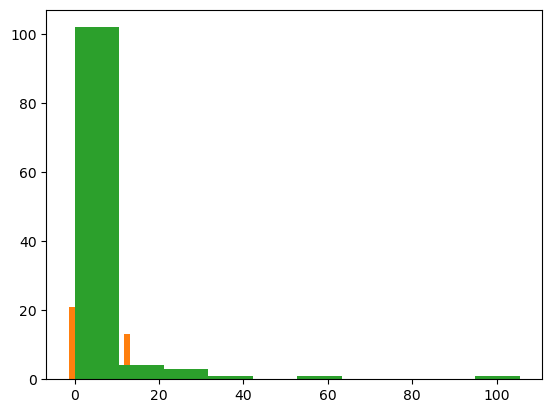

In [791]:
import matplotlib.pyplot as plt
plt.hist(f_mean, bins=10)
plt.hist(fw_mean_original, bins=10)
plt.hist(val_y, bins=10)

In [779]:
np.max(f_mean), np.max(fw_mean_original), np.max(val_y)

(2.827188029208113, 13.222190285748855, 105.5)

In [778]:
np.mean(f_mean), np.mean(fw_mean_original), np.mean(val_y)

(0.667671150181275, 5.320475449775332, 4.698083928571429)

In [780]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

print(np.vstack((f_mean.reshape(-1), fw_mean_original.reshape(-1), np.array(val_y).reshape(-1))).T)


[[0.372301 -1.367498 0.000000]
 [0.035242 -0.978207 0.984000]
 [0.037350 -0.992599 1.405000]
 [0.039556 -1.004324 1.895000]
 [0.041863 -1.013364 1.990000]
 [0.044274 -1.019698 105.500000]
 [0.046790 -1.023309 28.300000]
 [0.049415 -1.024178 6.700000]
 [0.052149 -1.022286 9.210000]
 [0.054996 -1.017615 9.710000]
 [0.057958 -1.010149 6.250000]
 [0.061035 -0.999870 6.870000]
 [0.064230 -0.986761 7.550000]
 [0.126677 -0.440637 9.340000]
 [0.131778 -0.380362 0.949000]
 [0.136985 -0.317044 0.950000]
 [0.142294 -0.250678 1.100000]
 [0.147700 -0.181254 1.595000]
 [0.153199 -0.108767 2.460000]
 [0.158786 -0.033210 1.610000]
 [0.164456 0.045423 3.860000]
 [0.170203 0.127136 2.650000]
 [0.176021 0.211934 3.250000]
 [0.181903 0.299821 1.890000]
 [0.187843 0.390801 1.830000]
 [0.193833 0.484874 1.700000]
 [0.199866 0.582045 1.440000]
 [0.205934 0.682314 2.480000]
 [0.212028 0.785682 1.115000]
 [0.218141 0.892149 0.630000]
 [0.224262 1.001715 1.315000]
 [0.230384 1.114379 2.180000]
 [0.236496 1.2301

In [736]:


fig = px.scatter_3d(val_subset, x=val_subset['EAST_mid_tf'], y=val_subset['NORTH_mid_tf'], z=val_subset['RL_mid_tf'],
              color=val_subset['Cu_pct'], color_continuous_scale='viridis')




fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=21, range=[0,2100],),
                     yaxis = dict(nticks=15, range=[0,1500],),
                     zaxis = dict(nticks=18, range=[0,1770],),),
    width=700,
    margin=dict(r=20, l=10, b=10, t=10))

fig.update_traces(marker_size = 4)

fig.show()

In [735]:


fig = px.scatter_3d(val_subset, x=val_subset['EAST_mid_tf'], y=val_subset['NORTH_mid_tf'], z=val_subset['RL_mid_tf'],
              color=fw_mean_original, color_continuous_scale='viridis')




fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=21, range=[0,2100],),
                     yaxis = dict(nticks=15, range=[0,1500],),
                     zaxis = dict(nticks=18, range=[0,1770],),),
    width=700,
    margin=dict(r=20, l=10, b=10, t=10))

fig.update_traces(marker_size = 4)

fig.show()

In [734]:
fw_mean_original =fw_mean_original.reshape(-1)
np.shape(fw_mean_original)

(112,)